# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [1]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.metrics import mean_squared_error


optimizers = ["gradient_descent", "spsa", "adam"]
train_types= ['vqe','meta', 'opt_meta']

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)  

fci_energies = fci_h2["energies"]


f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break



In [2]:
# Ordered by pairs - fd,ps
main_groups = [ "simplified2design_4layers_fd", "simplified2design_4layers_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps", "kupccgsd_1layers_fd", "kupccgsd_1layers_ps", ]

In [3]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'./{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:{"errors":[0.0 for _ in train_types], "runs":[ 0 for _ in train_types]} for i in optimizers}
    for opt in optimizers:
        for data_entry in this_group:
            for count, result_type in enumerate(train_types):
                if result_type == 'meta':
                    group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, data_entry['results'][opt][result_type]["energies_after_meta"], squared=False)*1000/len(this_group)

                else:
                    group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, [energy[-1] for energy in data_entry['results'][opt][result_type]["energies"]], squared=False)*1000/len(this_group)                    

    condensed_data.append(group_dict)


In [4]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [5]:
import pandas as pd

result_types = ['vqe', 'meta', 'opt-meta']
arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in result_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type))

In [6]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps')]

In [7]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:.3f}'.format
df

Gradient            SPSA            ADAM   
                                         fd      ps      fd      ps      fd   
simplified2design-4layers vqe       854.324  54.734 181.795 147.638 673.237  \
                          meta      863.937 846.799 632.235 586.507 816.570   
                          opt-meta  812.076 168.150 371.659 411.209 792.859   
meta-single-doubles       vqe       595.586   4.873  12.187  19.645 109.237   
                          meta      610.868 282.837 180.910 214.363 201.429   
                          opt-meta  654.683  57.206  96.391 115.681 185.635   
meta-doubles              vqe       602.135   3.436   8.297  11.534  87.357   
                          meta      172.344  73.782 159.681 101.683 197.089   
                          opt-meta  554.103  18.614  33.831  53.073 139.945   
kupccgsd-1layers          vqe       634.205   1.361   4.222   5.455  82.542   
                          meta      596.225 354.612 147.007 106.900 323.514   
                          opt-meta  636.187  10.966 103.582 112.780 281.916   

                                            
                                        ps  
simplified2design-4layers vqe        5.695  
                          meta     833.424  
                          opt-meta  98.876  
meta-single-doubles       vqe       26.615  
                          meta     268.976  
                          opt-meta  94.520  
meta-doubles              vqe        1.355  
                          meta      69.279  
                          opt-meta  38.397  
kupccgsd-1layers          vqe        0.990  
                          meta     438.432  
                          opt-meta  24.317

In [8]:
print(df.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{Gradient} & \multicolumn{2}{r}{SPSA} & \multicolumn{2}{r}{ADAM} \\
 &  & fd & ps & fd & ps & fd & ps \\
\midrule
\multirow[t]{3}{*}{simplified2design-4layers} & vqe & 854.324 & 54.734 & 181.795 & 147.638 & 673.237 & 5.695 \\
 & meta & 863.937 & 846.799 & 632.235 & 586.507 & 816.570 & 833.424 \\
 & opt-meta & 812.076 & 168.150 & 371.659 & 411.209 & 792.859 & 98.876 \\
\cline{1-8}
\multirow[t]{3}{*}{meta-single-doubles} & vqe & 595.586 & 4.873 & 12.187 & 19.645 & 109.237 & 26.615 \\
 & meta & 610.868 & 282.837 & 180.910 & 214.363 & 201.429 & 268.976 \\
 & opt-meta & 654.683 & 57.206 & 96.391 & 115.681 & 185.635 & 94.520 \\
\cline{1-8}
\multirow[t]{3}{*}{meta-doubles} & vqe & 602.135 & 3.436 & 8.297 & 11.534 & 87.357 & 1.355 \\
 & meta & 172.344 & 73.782 & 159.681 & 101.683 & 197.089 & 69.279 \\
 & opt-meta & 554.103 & 18.614 & 33.831 & 53.073 & 139.945 & 38.397 \\
\cline{1-8}
\multirow[t]{3}{*}{kupccgsd-1layers} & vqe & 634.205 

In [11]:
## Simplified: (WIRES + LAYERS*(WIRES-1)*2)
## Single Double Excitations: 1 per excitation
## kupccgsd: 6*LAYERS

## For fd: (Nvars*4)+1
overheads_fd = [113,13,5]

## For ps - simplified: (Nvars*2)*4
## For ps - excitations, kupccgsd: (Nvars*4)*4
overheads_ps = [224,48,16]

index_per_runs_plot_fd = [0,2,4]
index_per_runs_plot_ps = [1,3,5]

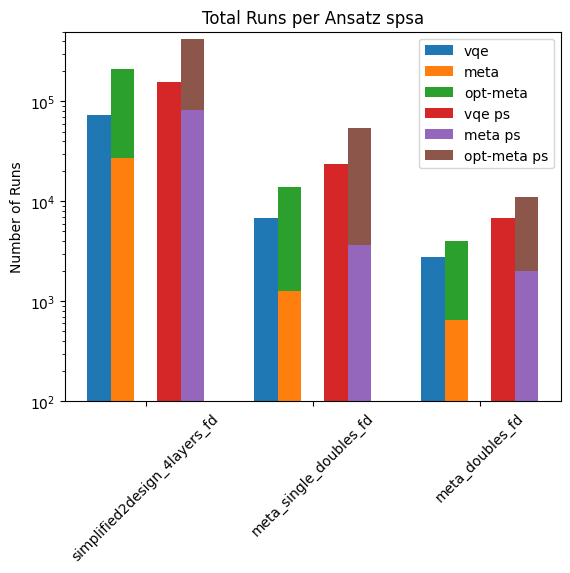

In [12]:
opt_runs = optimizers[1]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads_ps[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_data)) 

width = 0.14                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(2*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_data_ps))+ width*3, vqe_data_ps, width=width, label="vqe ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*4, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*4, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.yscale('log')
plt.ylim(100, 500000)
plt.show()

[16198.0, 29719.0, 2027.9999999999998, 680.0, 3850.0]


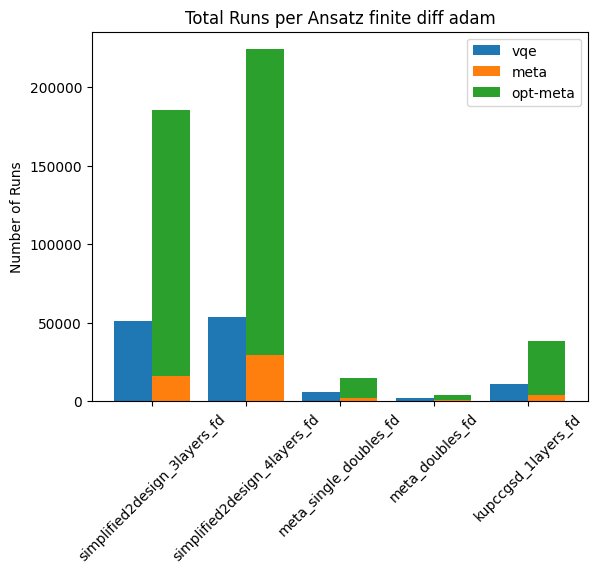

In [ ]:
opt_runs = optimizers[2]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()